# Decision Tree Classifier

Decision Tree Classifier will use a feature's data to split the sample using Gini information gain to determine its path. Each split happens with different features until it reaches the stopping criteria. The model will then use the test sample to determine if the boolean training sample splits were correct. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_dummies.csv')

In [3]:
df= df.drop(columns=['Unnamed: 0'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168018 entries, 0 to 168017
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Month       168018 non-null  int64
 1   DayofMonth  168018 non-null  int64
 2   ArrTime     168018 non-null  int64
 3   DepDelay    168018 non-null  int64
 4   Distance    168018 non-null  int64
 5   DayofWeek   168018 non-null  int64
 6   Dest_ATL    168018 non-null  int64
 7   Dest_DEN    168018 non-null  int64
 8   Dest_DFW    168018 non-null  int64
 9   Dest_LAX    168018 non-null  int64
 10  Dest_ORD    168018 non-null  int64
dtypes: int64(11)
memory usage: 14.1 MB


In [5]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print()

Month
6     19143
1     17009
3     16487
2     16348
7     15713
5     14963
12    14597
4     14332
8     13911
9      9260
10     8420
11     7835
Name: Month, dtype: int64

DayofMonth
7     6410
22    6221
21    5899
1     5887
19    5836
14    5731
2     5674
15    5671
8     5668
11    5571
3     5571
9     5568
27    5516
17    5513
20    5423
18    5412
25    5408
24    5381
26    5335
28    5315
16    5309
29    5308
12    5304
13    5235
5     5223
6     5148
10    5130
4     5081
23    5067
30    5000
31    3203
Name: DayofMonth, dtype: int64

ArrTime
2019    322
2036    303
2052    303
2012    302
2027    299
       ... 
429       1
253       1
407       1
251       1
240       1
Name: ArrTime, Length: 1352, dtype: int64

DepDelay
1    112852
0     55166
Name: DepDelay, dtype: int64

Distance
802     5441
1745    5198
888     4412
1235    3959
641     3580
        ... 
1014      10
1081       8
3414       7
784        2
373        2
Name: Distance, Length: 329, dtype: int64

In [6]:
# set x and y
X = df.drop(columns=['DepDelay'], axis=1)
y= df['DepDelay']

In [7]:
#train test split: split train and test data into different randomly chosen samples
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, train_size=.8, random_state=42)

In [8]:
#standard scaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [9]:
scaler_X_train = scaler.transform(X_train)
scaler_X_test = scaler.transform(X_test)

### Baseline DTC 

In [10]:
dtc = DecisionTreeClassifier()
dtc.fit(scaler_X_train, y_train)

DecisionTreeClassifier()

In [11]:
df_col = list(df.columns)
df_col.remove('DepDelay')

##### Feature Importance 

In [12]:
df_feat = pd.DataFrame(dtc.feature_importances_, index=df_col, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feat

,feature importance
ArrTime,0.340883
Distance,0.223071
DayofMonth,0.180154
Month,0.126977
DayofWeek,0.103286
Dest_DEN,0.006767
Dest_DFW,0.006680
Dest_ORD,0.006584
Dest_LAX,0.003361
Dest_ATL,0.002237


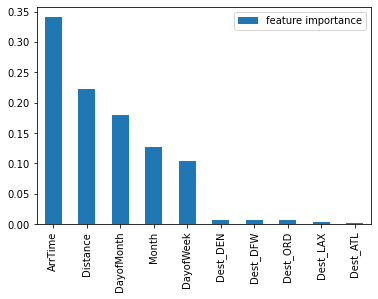

In [13]:
df_feat.plot(kind='bar');

##### Model Train

In [14]:
dtc_pred_train = dtc.predict(scaler_X_train)

##### Model Test

In [15]:
dtc_pred_test = dtc.predict(scaler_X_test)

In [16]:
print(classification_report(y_test, dtc_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.44      0.46      0.45     10983
       Delay       0.73      0.72      0.73     22621

    accuracy                           0.63     33604
   macro avg       0.59      0.59      0.59     33604
weighted avg       0.64      0.63      0.64     33604



In [17]:
print('Mean Absolute Error:', mean_absolute_error(y_test, dtc_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, dtc_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, dtc_pred_test)))

Mean Absolute Error: 0.3653731698607309
Mean Squared Error: 0.3653731698607309
Root Mean Squared Error: 0.6044610573566596


##### Confusion Matrix

In [18]:
base_cnf_matrix = confusion_matrix(y_test, dtc_pred_test)
base_cnf_matrix

array([[ 5026,  5957],
       [ 6321, 16300]], dtype=int64)

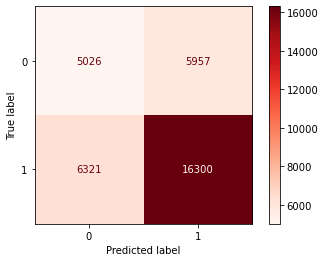

In [19]:
plot_confusion_matrix(dtc, scaler_X_test, y_test,
                      cmap=plt.cm.Reds)
plt.show()

### Random Search

Random Search will use all the combinations of hyperparameters to determine the best combination for the most accurate boolean sample splits.

In [20]:
param_grid={
    'criterion':['gini', 'entropy'],
    'random_state': [1,20, 42, 100 ],
    'max_depth':[5,10,20,30,40,50,60,70],
    'min_samples_split':[5,10,20,25,30,40,50],
    'min_samples_leaf':[1,100,200,300,400,500]
            }

In [21]:
dtc_rand_search = RandomizedSearchCV(dtc, param_grid)

##### Model Train

In [22]:
dtc_rand_search.fit(scaler_X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20, 30, 40, 50, 60,
                                                      70],
                                        'min_samples_leaf': [1, 100, 200, 300,
                                                             400, 500],
                                        'min_samples_split': [5, 10, 20, 25, 30,
                                                              40, 50],
                                        'random_state': [1, 20, 42, 100]})

In [23]:
dtc_rand_search.best_params_

{'random_state': 20,
 'min_samples_split': 5,
 'min_samples_leaf': 300,
 'max_depth': 60,
 'criterion': 'gini'}

In [24]:
dtc_rs_pred_train = dtc_rand_search.predict(scaler_X_train)

In [25]:
print(classification_report(y_train, dtc_rs_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.57      0.13      0.22     44183
       Delay       0.69      0.95      0.80     90231

    accuracy                           0.68    134414
   macro avg       0.63      0.54      0.51    134414
weighted avg       0.65      0.68      0.61    134414



In [26]:
print('Mean Absolute Error:', mean_absolute_error(y_train, dtc_rs_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, dtc_rs_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, dtc_rs_pred_train)))

Mean Absolute Error: 0.3177124406683828
Mean Squared Error: 0.3177124406683828
Root Mean Squared Error: 0.5636598625664088


##### Model Test

In [27]:
dtc_rs_pred_test = dtc_rand_search.predict(scaler_X_test)

In [28]:
print(classification_report(y_test, dtc_rs_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.54      0.13      0.21     10983
       Delay       0.69      0.95      0.80     22621

    accuracy                           0.68     33604
   macro avg       0.61      0.54      0.50     33604
weighted avg       0.64      0.68      0.61     33604



In [29]:
print('Mean Absolute Error:', mean_absolute_error(y_test, dtc_rs_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, dtc_rs_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, dtc_rs_pred_test)))

Mean Absolute Error: 0.32115224378050233
Mean Squared Error: 0.32115224378050233
Root Mean Squared Error: 0.5667029590363035


##### Confusion Matrix

In [30]:
cnf_matrix = confusion_matrix(y_test, dtc_rs_pred_test)
cnf_matrix

array([[ 1413,  9570],
       [ 1222, 21399]], dtype=int64)

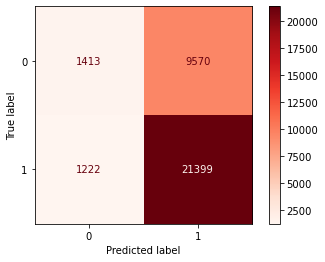

In [31]:
plot_confusion_matrix(dtc_rand_search, scaler_X_test, y_test,
                      cmap=plt.cm.Reds)
plt.show()

### Smote 

In [32]:
# 0: On Time, 1: Delay
df['DepDelay'].value_counts()

1    112852
0     55166
Name: DepDelay, dtype: int64

There is a large difference between the data's On Time and Delay classifications, so upsampling with SMOTE may help my model train better. 

In [33]:
smote = SMOTE()

##### Model Train

In [34]:
X_train_resampled, y_train_resampled = smote.fit_resample(scaler_X_train, y_train) 

In [35]:
dtc_rand_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20, 30, 40, 50, 60,
                                                      70],
                                        'min_samples_leaf': [1, 100, 200, 300,
                                                             400, 500],
                                        'min_samples_split': [5, 10, 20, 25, 30,
                                                              40, 50],
                                        'random_state': [1, 20, 42, 100]})

In [36]:
dtc_smote_pred_train = dtc_rand_search.predict(X_train_resampled)

In [37]:
print(classification_report(y_train_resampled, dtc_smote_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.94      0.97      0.96     90231
       Delay       0.97      0.94      0.96     90231

    accuracy                           0.96    180462
   macro avg       0.96      0.96      0.96    180462
weighted avg       0.96      0.96      0.96    180462



In [38]:
print('Mean Absolute Error:', mean_absolute_error(y_train_resampled, dtc_smote_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train_resampled, dtc_smote_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train_resampled, dtc_smote_pred_train)))

Mean Absolute Error: 0.04399264111003979
Mean Squared Error: 0.04399264111003979
Root Mean Squared Error: 0.20974422783485555


##### Model Test

In [39]:
X_test_resampled, y_test_resampled = smote.fit_resample(scaler_X_test, y_test) 

In [40]:
dtc_smote_pred_test = dtc_rand_search.predict(X_test_resampled)

In [41]:
print(classification_report(y_test_resampled, dtc_smote_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.65      0.63      0.64     22621
       Delay       0.64      0.66      0.65     22621

    accuracy                           0.65     45242
   macro avg       0.65      0.65      0.65     45242
weighted avg       0.65      0.65      0.65     45242



In [42]:
print('Mean Absolute Error:', mean_absolute_error(y_test_resampled, dtc_smote_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test_resampled, dtc_smote_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_resampled, dtc_smote_pred_test)))

Mean Absolute Error: 0.35124441890278946
Mean Squared Error: 0.35124441890278946
Root Mean Squared Error: 0.5926587710502473


##### Confusion Matrix

In [43]:
cnf_matrix = confusion_matrix(y_test_resampled, dtc_smote_pred_test)
cnf_matrix

array([[14359,  8262],
       [ 7629, 14992]], dtype=int64)

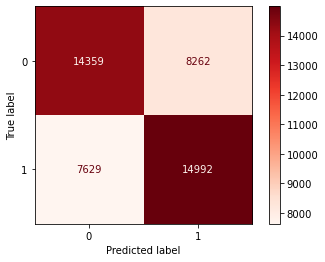

In [44]:
plot_confusion_matrix(dtc_rand_search, X_test_resampled, y_test_resampled,
                      cmap=plt.cm.Reds)
plt.show()